In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import matplotlib.patches as patches
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import fisher_exact
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from pycirclize import Circos
from scipy.interpolate import splprep, splev
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
from itertools import combinations
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# Load marker genes

In [2]:
def load_pathway(fpath):
    """
    Loads an Enrichr-like database file into a boolean DataFrame.

    Args:
        fpath (str): Path to the Enrichr-like database file.

    Returns:
        pandas.DataFrame: A boolean DataFrame where:
            - Index: Genes
            - Columns: Pathways
            - Values: True if the gene is in the pathway, False otherwise.
    """

    result = []
    with open(fpath,  encoding='utf-8') as f:
        for line in f:
            split_line = [x for x in line.strip().split('\t') if x]  # Remove empty strings directly

            row = {'label': split_line[0]}
            for gene in split_line[1:]:
                row[gene] = 1

            result.append(row)

    df = pd.DataFrame(result)
    df = df.fillna(0.0).set_index('label').astype(bool).T  # Chained operations for clarity

    return df

fpath = "../../ONT-single-cell/resources/PanglaoDB_Augmented_2021.txt"
pdf = load_pathway(fpath)
stem_genes = list(pdf[pdf['Embryonic Stem Cells']].index)
stem_genes = [x.title() for x in stem_genes]
stem_genes[:10]

['Gjb1',
 'Amotl2',
 'Yap1',
 'Fbln1',
 'Uaca',
 'Antxr1',
 'Fermt2',
 'Serpinh1',
 'Pls3',
 'Gpx8']

# Load scores

In [3]:
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_{resolution}_scores.csv"
scores = pd.read_csv(fpath)
print(f"{scores.shape=}")

scores.head()

scores.shape=(2431, 36)


,bin_name,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# Load genes mapping

In [4]:
""" LOAD the TF list """
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"
tf_list = [x.strip() for x in open(fpath)]

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)
df['is_marker'] = df['gene_name'].isin(stem_genes)


""" MERGE the core scores """
merge_columns = [
    'bin_name',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_5',
    'global_hge_logexp_RNA_weighted'
]

df = pd.merge(
    df, scores[merge_columns].fillna(0.0), how="left",
)

""" DEFINE the core """
order_threshold = 3
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(df[score_column], core_threshold_quantile)
df['is_core'] = df[score_column] > threshold

print(f"{df.shape=}")
df.head()

df.shape=(4939267, 13)


,gene_name,gene_biotype,read_name,bin_name,is_tf,is_marker,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,False,0.826484,1.149226,1.349552,0.866066,0.573875,0.254849,False
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,False,0.497386,0.547185,0.336787,0.839273,0.141617,0.157878,False
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,False,0.754788,1.027046,1.577616,0.839461,0.906364,0.491722,False
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,False,0.690311,0.851758,0.774613,0.833768,0.617768,0.310082,False
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,False,0.767515,0.921479,1.337415,0.571748,0.508463,0.289030,False


# Highest average core score

In [5]:
pt_only = True
core_only = False

pdf = df.copy()
pdf['chrom'] = pdf['bin_name'].str.split(":").str[0]

""" FILTER reads and genes """
if pt_only:
    pdf = pdf[pdf['gene_biotype'] == 'protein_coding']

if core_only:
    pdf = pdf[pdf['is_core']]
    

def nan_counts(x):
    return np.count_nonzero(np.isnan(x)) 

pdf = pdf.groupby('read_name').agg(
    n_bins=('bin_name', 'nunique'),
    n_chroms=('chrom', 'nunique'),
    n_core_loci=('is_core', 'sum'),
    n_genes=('gene_name', 'count'),
    n_markers=('is_marker', 'sum'),
    n_tfs=('is_tf', 'sum'),
    RNA=('RNA_5', 'mean'),
    ATAC=('ATACSeq_1', 'mean'),
    CTCF=('CTCF', 'mean'),
    H3K27ac=('H3K27ac', 'mean'),
    H3K27me3=('H3K27me3', 'mean'),
    core_score=('global_hge_logexp_RNA_weighted', 'mean'),
    is_na=('global_hge_logexp_RNA_weighted', nan_counts),
).reset_index()

pdf = pdf.sort_values(by='core_score', ascending=False)
print(f"{pdf.shape=}")
pdf.head()

pdf.shape=(2023055, 14)


,read_name,n_bins,n_chroms,n_core_loci,n_genes,n_markers,n_tfs,RNA,ATAC,CTCF,H3K27ac,H3K27me3,core_score,is_na
655613,530b641b-114c-4822-88f5-af01bb22eb59,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0
1005591,7f51f5ed-fd5c-4b6b-9ac5-81788bc02c57,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0
714884,5a7ee56a-4a76-4916-bcdd-6d2db3e985e6,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0
653732,52cdb663-d264-4eaf-b1da-88f5b892d9d4,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0
1597457,ca114a94-7cbb-4ca2-92c4-efb45da4f3b7,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0


# Summarize and plot

In [6]:
# number of reads with at least one transcription factor
gdf = pdf.copy()
gdf['has_tf'] = gdf['n_tfs'] > 0
gdf['has_marker'] = gdf['n_markers'] > 0

print(gdf['has_tf'].value_counts(normalize=False))
print(gdf['has_marker'].value_counts(normalize=False))


has_tf
False    1737203
True      285852
Name: count, dtype: int64
has_marker
False    1968458
True       54597
Name: count, dtype: int64


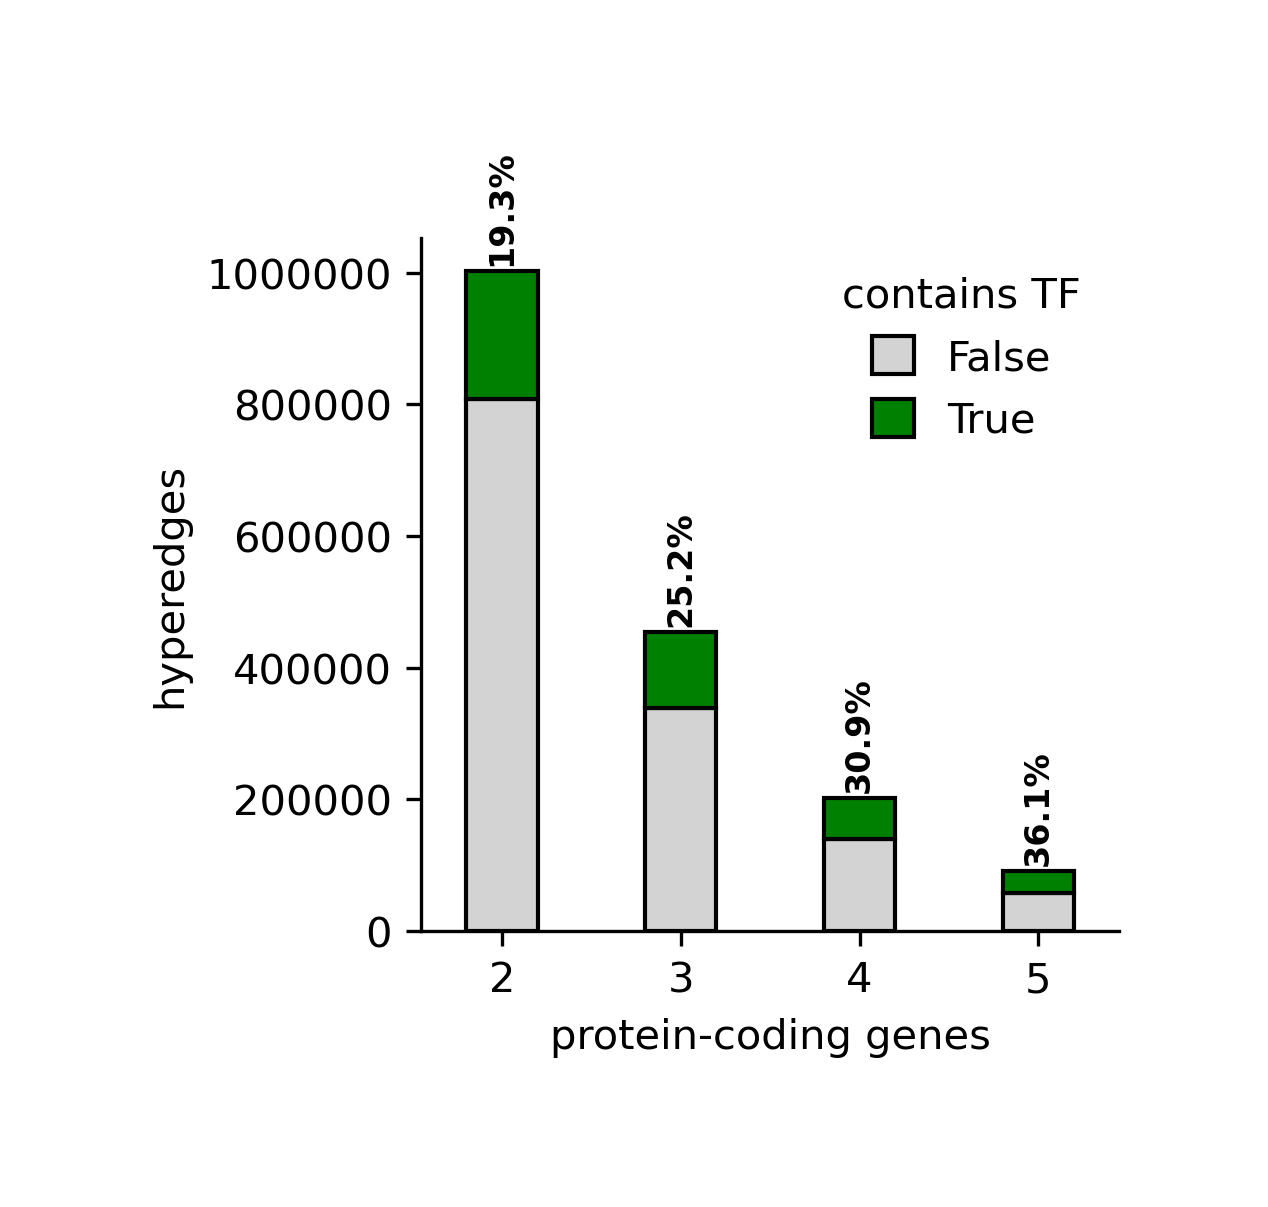

In [23]:
result = []

for order in [2, 3, 4, 5]:
    gdf = pdf.copy()
    gdf = gdf[gdf['n_genes'] >= order]
    gdf = gdf[gdf['is_na'] == 0.0]
    gdf['has_tf'] = gdf['n_tfs'] > 0
    row = gdf['has_tf'].value_counts(normalize=False).to_dict()
    row['order'] = order
    # row['total'] = len(gdf)
    result.append(row)

result = pd.DataFrame(result) 
result = result.set_index('order')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

# Plot stacked bars
result.plot(
    kind='bar', 
    stacked=True,
    ec='k',
    lw=1,
    width=0.4,
    color=['lightgrey', 'green'],
)

plt.xlabel("protein-coding genes")
plt.ylabel("hyperedges")
plt.xticks(rotation=0)  

ax = plt.gca()

sns.move_legend(
    ax,
    title='contains TF',
    loc='best',
)

# Annotate with percentages
for i, patch in enumerate(ax.patches):
    if i >= len(result):  # Only annotate the 'True' patches
        height = patch.get_height() 
        total = result.iloc[i % len(result)].sum()  # Get total for the corresponding order
        percentage = (height / total) * 100
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_y() + patch.get_height() + 20000  # Adjust vertical position as needed
        ax.annotate(f"{percentage:.1f}%", (x, y), fontsize=8, fontweight='bold', rotation=90, ha='center')

plt.ticklabel_format(axis='y', style='plain') 
sns.despine()

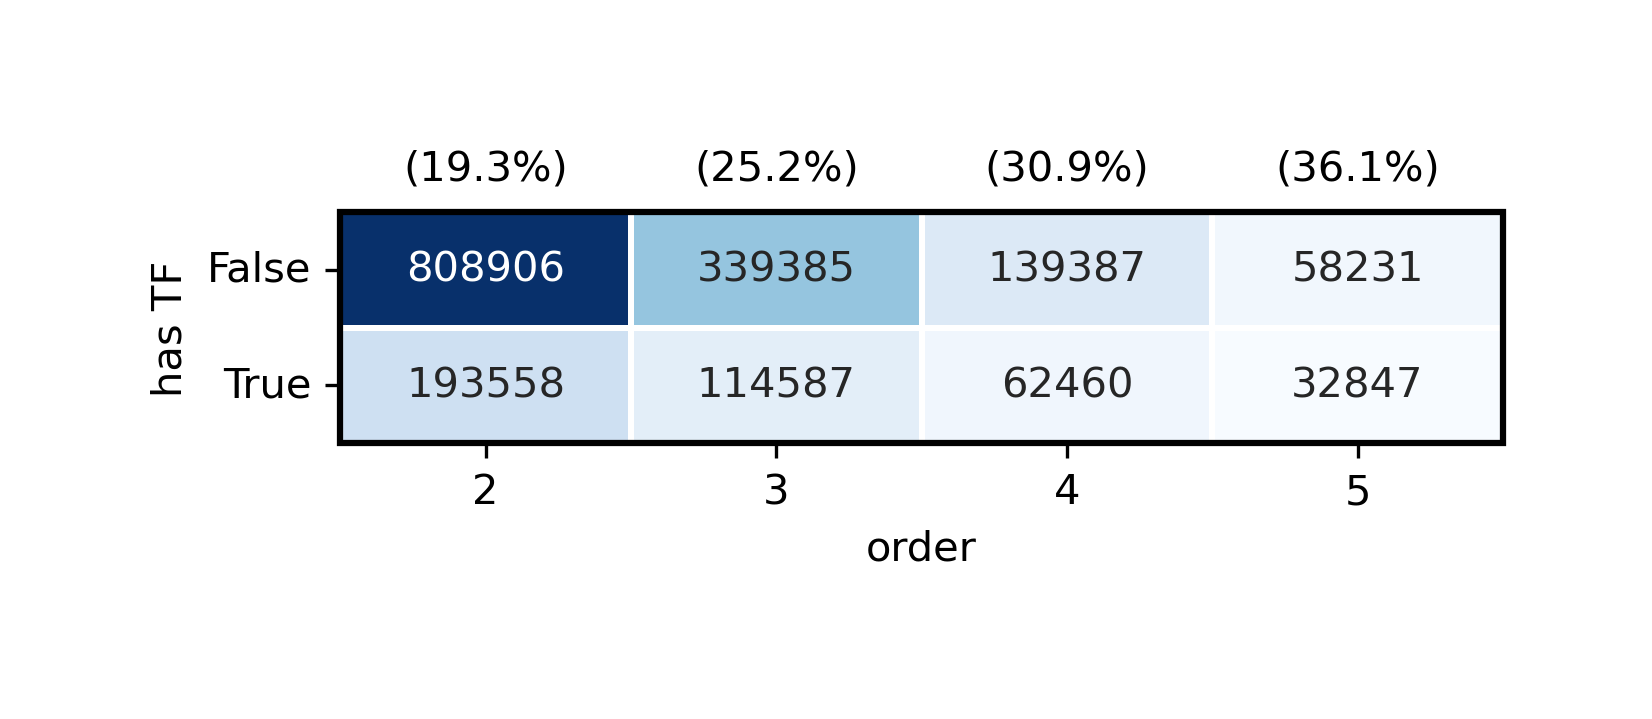

In [53]:
X = result.copy()
X = X.T

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 1

sns.heatmap(
    X,
    lw=1,
    cmap='Blues',
    cbar=False,
    annot=True, fmt=".0f"  # Add annotations with 2 decimal places
)

ax = plt.gca()

ax.set_ylabel("has TF")
ax.set_xlabel("order")
ax.tick_params(axis='both', rotation=0)


# Add black border around the entire heatmap
ax.add_patch(
    plt.Rectangle((0,0), X.shape[1], X.shape[0], 
                  fill=False, 
                  edgecolor='black',
                  lw=1.5,
                  clip_on=False))


# Calculate percentage True per column
percent_true = (X.loc[True] / X.sum()) * 100

    # Annotate column sums on the top
for j, percent in enumerate(percent_true):
    ax.text(
        j + 0.5, y_lims[1] - 0.2, 
        f"({percent:.1f}%)", 
        ha='center', 
        va='bottom',
        rotation=0,
    )
# print(X.to_string())

In [8]:
total = 2756467

reads_with_genes = df['read_name'].nunique()
print(f"total reads with genes {reads_with_genes} ({100*(reads_with_genes / total):.3f}%)")

reads_with_pt_genes = df[df['gene_biotype'] == 'protein_coding']['read_name'].nunique()
print(f"total reads with genes {reads_with_pt_genes} ({100*(reads_with_pt_genes / total):.3f}%)")

reads_with_tf_genes = df[df['is_tf']]['read_name'].nunique()
print(f"total reads with genes {reads_with_tf_genes} ({100*(reads_with_tf_genes / total):.3f}%)")


total reads with genes 2200583 (79.833%)
total reads with genes 2023055 (73.393%)
total reads with genes 286125 (10.380%)


In [9]:
order_threshold = 2
gdf = pdf.copy()

# gdf = gdf[gdf['n_bins'] > 1]
# gdf = gdf[gdf['n_chroms'] > 1]
# gdf = gdf[gdf['n_genes'] >= order_threshold]
gdf = gdf[gdf['is_na'] == 0.0]

gdf['has_tf'] = gdf['n_tfs'] > 0
gdf['has_marker'] = gdf['n_markers'] > 0
gdf['log_RNA'] = np.log1p(gdf['RNA'])
gdf['log_H3K27ac'] = np.log1p(gdf['H3K27ac'])

print(f"{gdf.shape=}")

gdf.head()

gdf.shape=(1888607, 18)


,read_name,n_bins,n_chroms,n_core_loci,n_genes,n_markers,n_tfs,RNA,ATAC,CTCF,H3K27ac,H3K27me3,core_score,is_na,has_tf,has_marker,log_RNA,log_H3K27ac
655613,530b641b-114c-4822-88f5-af01bb22eb59,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0,False,False,0.0,0.207021
1005591,7f51f5ed-fd5c-4b6b-9ac5-81788bc02c57,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0,False,False,0.0,0.207021
714884,5a7ee56a-4a76-4916-bcdd-6d2db3e985e6,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0,False,False,0.0,0.207021
653732,52cdb663-d264-4eaf-b1da-88f5b892d9d4,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0,False,False,0.0,0.207021
1597457,ca114a94-7cbb-4ca2-92c4-efb45da4f3b7,1,1,0,1,0,0,0.0,0.69631,0.465512,0.230008,0.619557,0.977649,0,False,False,0.0,0.207021


In [10]:
# gdf = pd.pivot_table(
#     pdf,
#     index='n_markers',
#     columns='n_tfs',
#     values='read_name',
#     aggfunc='count',
# )

# gdf

gdf['read_name'].nunique()=2023055
X.shape=(5, 8)


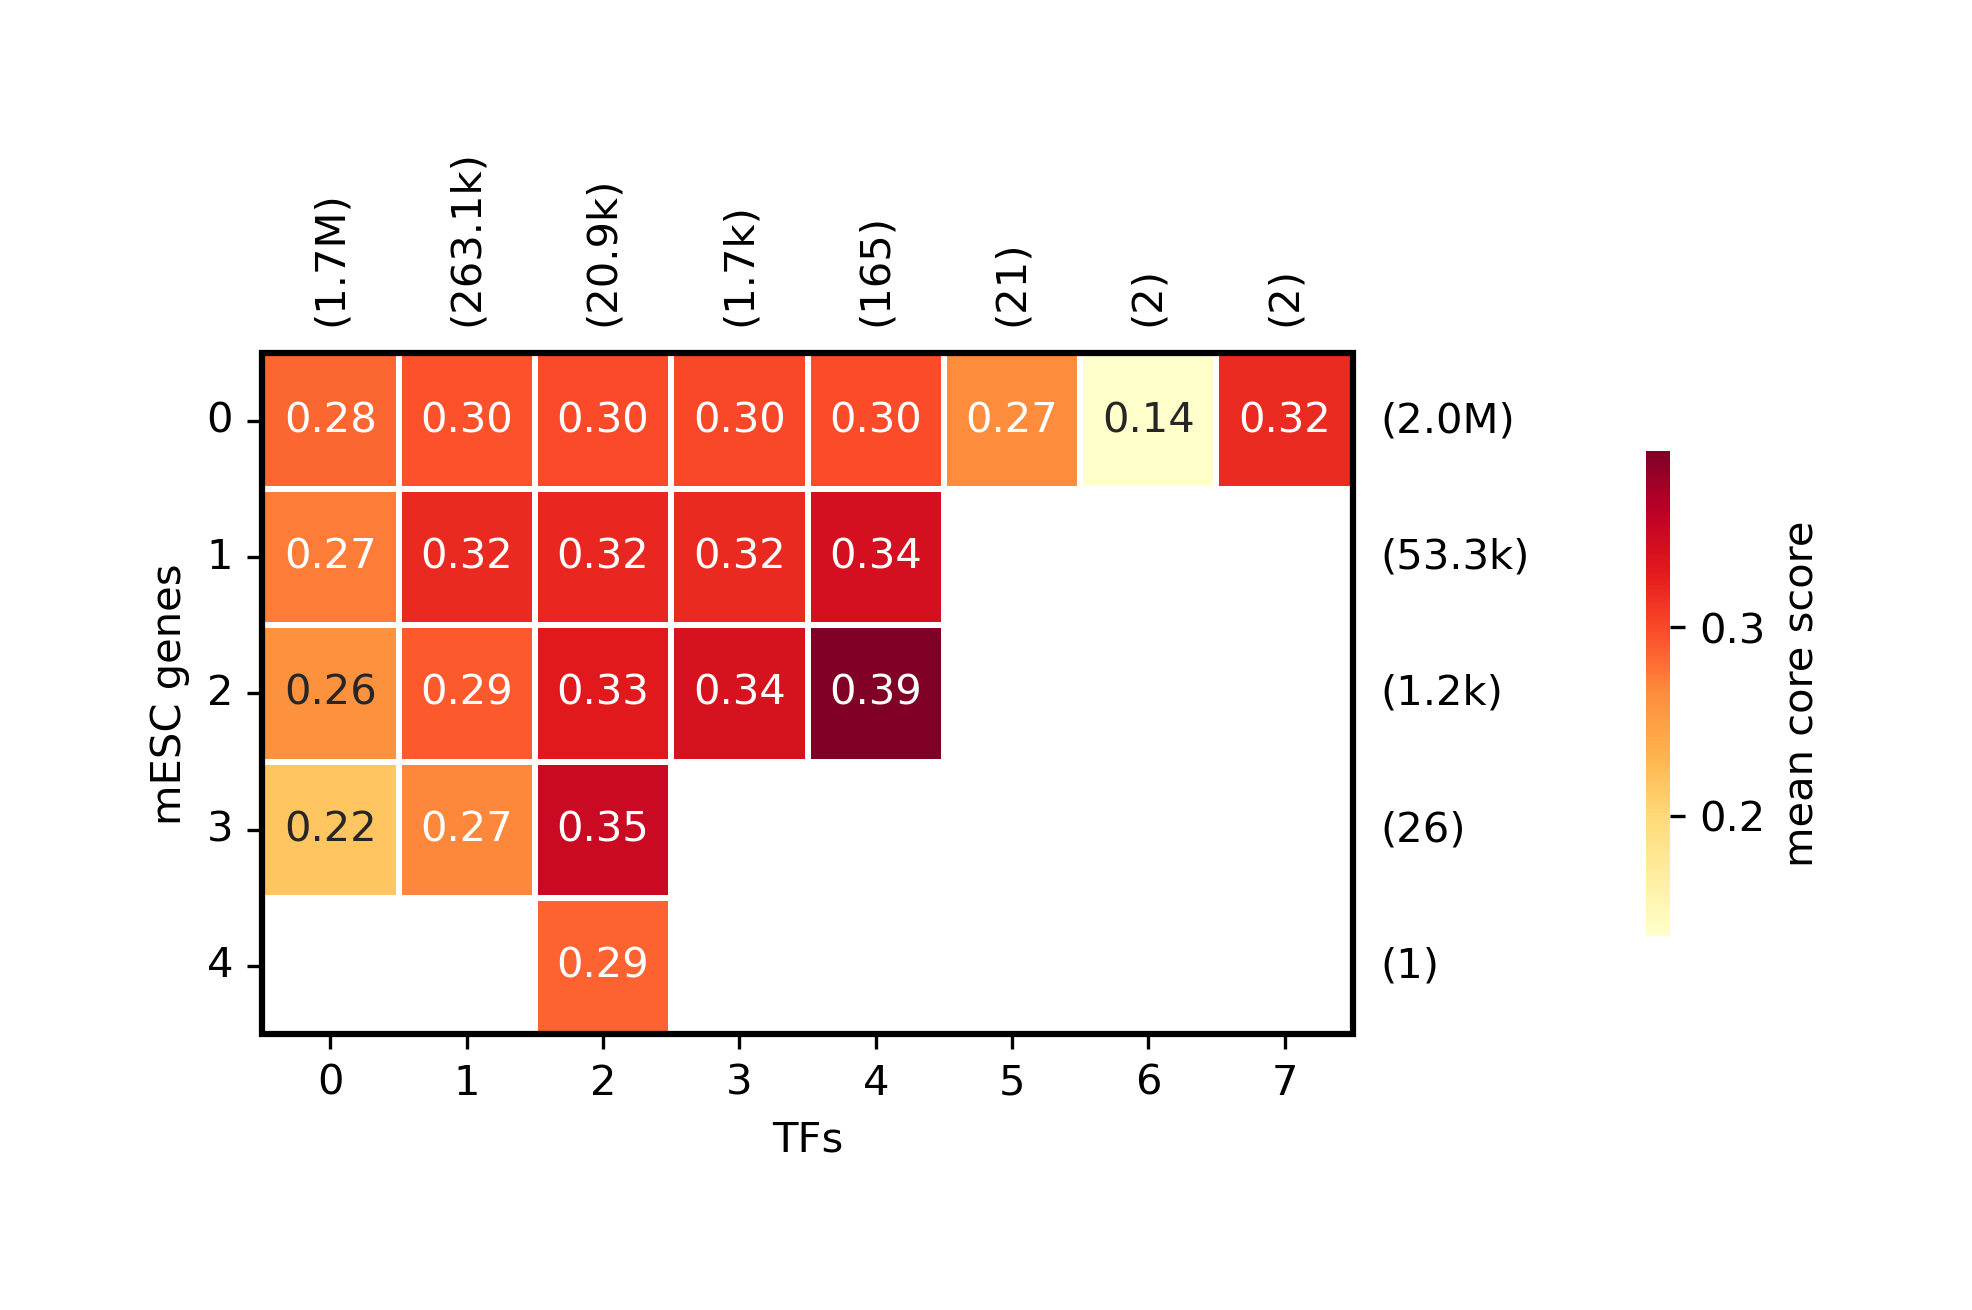

In [11]:
def format_array(arr):
  """
  Formats an array of numbers into a tuple of strings with appropriate units (k, M).

  Args:
    arr: A NumPy array of numbers.

  Returns:
    A tuple of formatted strings.
  """
  formatted_list = []
  for num in arr:
    if num >= 1e6:  # Millions
      formatted_list.append(f"({num/1e6:.1f}M)")
    elif num >= 1e3:  # Thousands
      formatted_list.append(f"({num/1e3:.1f}k)")
    else:
      formatted_list.append(f"({int(num)})")
  return tuple(formatted_list)
    

gdf = pdf.copy()
print(f"{gdf['read_name'].nunique()=}")

X = pd.pivot_table(
    gdf,
    index='n_markers',
    columns='n_tfs',
    values='core_score',
    aggfunc='mean',
)

print(f"{X.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    X,
    square=True,
    lw=1,
    cmap='YlOrRd',
    # cbar=False,
    cbar_kws={'shrink': 0.3, 'label' : 'mean core score', 'pad' : 0.18},
    annot=True, fmt=".2f"  # Add annotations with 2 decimal places
)

""" ORIGINAL axis labels """
ax = plt.gca()

ax.set_ylabel("mESC genes")
ax.set_xlabel("TFs")
ax.tick_params(axis='both', rotation=0)


""" ADDITIONAL axis labels """
# Calculate row and column sums
row_sums = gdf['n_markers'].value_counts()
col_sums = gdf['n_tfs'].value_counts()

# Get axis limits
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()

# Annotate row sums on the right
for i, row_sum in enumerate(row_sums):
    ax.text(
        x_lims[1] + 0.2, i + 0.5, 
        format_array([row_sum])[0], 
        ha='left', 
        va='center',
    )

    # Annotate column sums on the top
for j, col_sum in enumerate(col_sums):
    ax.text(
        j + 0.5, y_lims[1] - 0.2, 
        format_array([col_sum])[0], 
        ha='center', 
        va='bottom',
        rotation=90,
    )

# Add black border around the entire heatmap
ax.add_patch(
    plt.Rectangle((0,0), X.shape[1], X.shape[0], 
                  fill=False, 
                  edgecolor='black',
                  lw=1.5,
                  clip_on=False))

In [12]:
# break

gdf['read_name'].nunique()=2023055
X.shape=(3, 8)


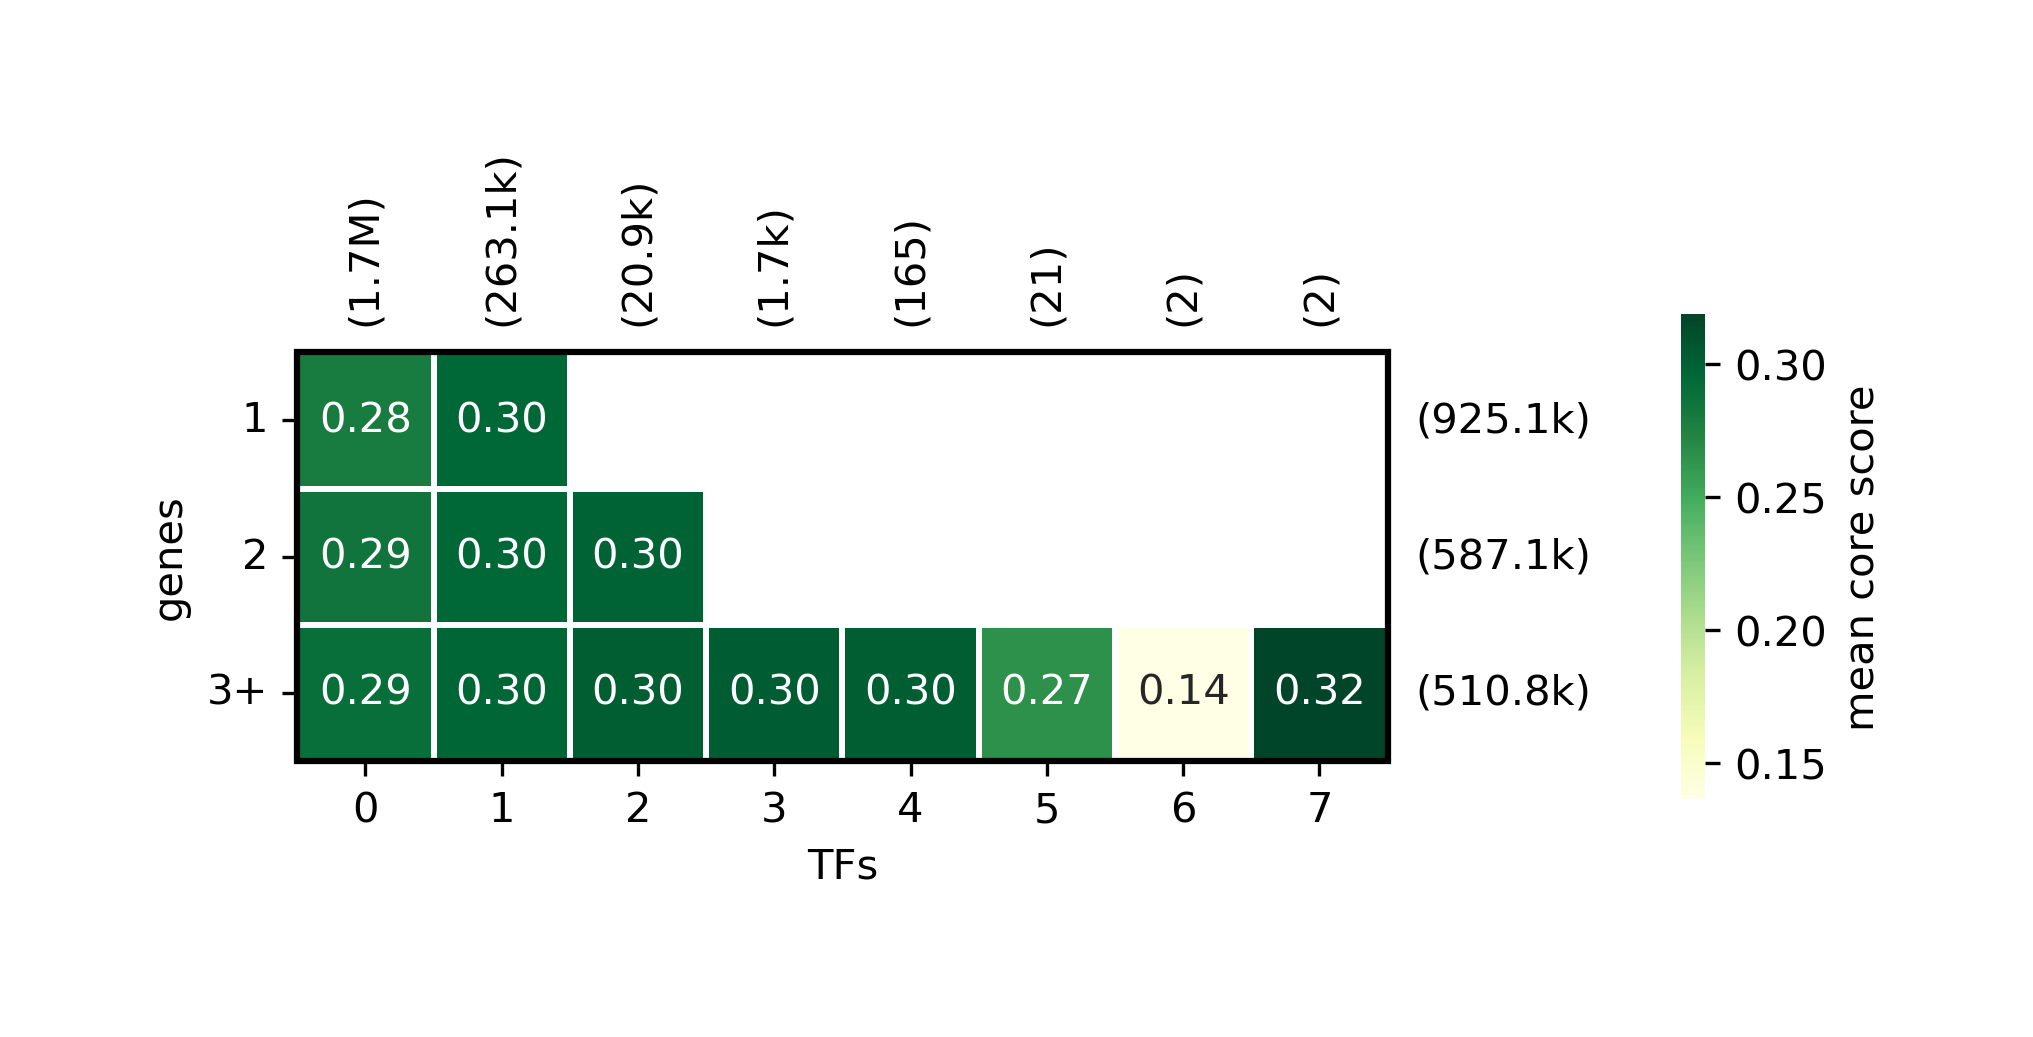

In [28]:
gdf = pdf.copy()
print(f"{gdf['read_name'].nunique()=}")
gdf['gene_count'] = gdf['n_genes'].apply(lambda x: str(x) if x <= 2 else '3+')

X = pd.pivot_table(
    gdf,
    index='gene_count',
    columns='n_tfs',
    values='core_score',
    aggfunc='mean',
)

print(f"{X.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    X,
    square=True,
    lw=1,
    cmap='YlGn',
    # cbar=False,
    cbar_kws={'shrink': 0.3, 'label' : 'mean core score', 'pad' : 0.18},
    annot=True, fmt=".2f"  # Add annotations with 2 decimal places
)

""" ORIGINAL axis labels """
ax = plt.gca()

ax.set_ylabel("genes")
ax.set_xlabel("TFs")
ax.tick_params(axis='both', rotation=0)


""" ADDITIONAL axis labels """
# Calculate row and column sums
row_sums = gdf['gene_count'].value_counts()
col_sums = gdf['n_tfs'].value_counts()

# Get axis limits
x_lims = ax.get_xlim()
y_lims = ax.get_ylim()

# Annotate row sums on the right
for i, row_sum in enumerate(row_sums):
    ax.text(
        x_lims[1] + 0.2, i + 0.5, 
        format_array([row_sum])[0], 
        ha='left', 
        va='center',
    )

    # Annotate column sums on the top
for j, col_sum in enumerate(col_sums):
    ax.text(
        j + 0.5, y_lims[1] - 0.2, 
        format_array([col_sum])[0], 
        ha='center', 
        va='bottom',
        rotation=90,
    )

# Add black border around the entire heatmap
ax.add_patch(
    plt.Rectangle((0,0), X.shape[1], X.shape[0], 
                  fill=False, 
                  edgecolor='black',
                  lw=1.5,
                  clip_on=False))

In [26]:
row_sums = gdf['gene_count'].value_counts()
row_sums

gene_count
1     925148
2     587122
3     277204
4     124893
5+    108688
Name: count, dtype: int64

In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# gdf = pdf.copy()
# print(f"{gdf['read_name'].nunique()=}")
# gdf['gene_count'] = gdf['n_genes'].apply(lambda x: str(x) if x <= 4 else '5+')

# gdf = pd.pivot_table(
#     gdf,
#     index='gene_count',
#     columns='n_tfs',
#     values='core_score',
#     aggfunc='mean',
# )

# print(f"{gdf.shape=}")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 7, 7

# sns.heatmap(
#     gdf,
#     square=True,
#     lw=1,
#     cmap='YlGn',
#     cbar_kws={'shrink': 0.3, 'label' : 'mean core score', 'pad' : 0.18},
#     annot=True, fmt=".2f"  # Add annotations with 2 decimal places
# )

# """ ORIGINAL axis labels """
# ax = plt.gca()

# ax.set_ylabel("genes")
# ax.set_xlabel("TFs")
# ax.tick_params(axis='both', rotation=0)


# """ ADDITIONAL axis labels """
# # Calculate row and column sums
# row_sums = pdf['gene_count'].value_counts()
# col_sums = pdf['n_tfs'].value_counts()

# # Get axis limits
# x_lims = ax.get_xlim()
# y_lims = ax.get_ylim()

# # Annotate row sums on the right
# for i, row_sum in enumerate(row_sums):
#     ax.text(
#         x_lims[1] + 0.2, i + 0.5, 
#         format_array([row_sum])[0], 
#         ha='left', 
#         va='center',
#     )

#     # Annotate column sums on the top
# for j, col_sum in enumerate(col_sums):
#     ax.text(
#         j + 0.5, y_lims[1] - 0.2, 
#         format_array([col_sum])[0], 
#         ha='center', 
#         va='bottom',
#         rotation=90,
#     )

# # Add black border around the entire heatmap
# ax.add_patch(
#     plt.Rectangle((0,0), gdf.shape[1], gdf.shape[0], 
#                   fill=False, 
#                   edgecolor='black',
#                   lw=1.5,
#                   clip_on=False))

In [ ]:
ax.get_ylim()

In [ ]:
gdf.shape[0]

In [ ]:
gdf = pdf.copy()

gdf = pd.pivot_table(
    gdf,
    index='n_markers',
    columns='n_tfs',
    values='core_score',
    aggfunc='mean',
)

print(f"{gdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    gdf,
    square=True,
    lw=1,
    cmap='YlOrRd',
    cbar_kws={'shrink': 0.35, 'label' : 'mean core score'},
    annot=True, fmt=".2f"  # Add annotations with 2 decimal places
)

""" ADD column sums """
ax = plt.gca()
# Create the divider
divider = make_axes_locatable(ax)
ax_top = divider.append_axes("top", size="45%", pad=0.1) 

sns.barplot(
    data=pdf['n_tfs'].value_counts(),
    ax=ax_top,
    color='lightgrey',
    width=0.6,
    ec='k',
    lw=1,
    # dodge=False,
)

ax_top.set_xticks([])
ax_top.set_xlabel("")
ax_top.set_ylabel("hyperedges")
sns.despine(ax=ax_top)

""" ADD row sums """
ax_right = divider.append_axes("right", size="45%", pad=0.1) 

sns.barplot(
    data=pdf['n_markers'].value_counts(),
    ax=ax_right,
    color='lightgrey',
    width=0.6,
    ec='k',
    lw=1,
    orient='h',
    # dodge=False,
)

ax_right.set_yticks([])
ax_right.set_ylabel("")
# ax_top.set_ylabel("hyperedges (log)")
sns.despine(ax=ax_right)


# # Add black border around the entire heatmap
# plt.gca().add_patch(
#     plt.Rectangle((0,0), gdf.shape[1], gdf.shape[0], 
#                   fill=False, 
#                   edgecolor='black',
#                   lw=1.5,
#                   clip_on=False))

ax.set_ylabel("n mESC genes")
ax.set_xlabel("n TFs")
ax.tick_params(axis='both', rotation=0)

gdf.head()

In [ ]:
pdf['n_tfs'].value_counts()

In [ ]:
pdf.head()

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

cmap = 'hot'

sns.scatterplot(
    data=gdf.sort_values(by='core_score'), 
    x='ATAC', 
    y='CTCF',
    ec='none',
    hue='core_score',
    s=3,
    palette=cmap,
    legend=False
)

plt.ylabel("CTCF")
plt.xlabel("ATAC-seq")

# Add colorbar
norm = plt.Normalize(gdf['core_score'].min(), gdf['core_score'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Adjust colorbar position and size
left = 0.95
width = 0.02
height = 0.35
bottom = height
cax = plt.gcf().add_axes([left, bottom, width, height])  # [left, bottom, width, height]
plt.colorbar(sm, shrink=0.5, label='core score', cax=cax)


sns.despine()

In [ ]:
break

# Pathway analysis

In [ ]:
fpath = "../../ONT-single-cell/resources/GO_Biological_Process_2023.txt"
pathways = load_pathway(fpath)
print(f"{pathways.shape=}")

columns = [
    'Regulation Of Stem Cell Differentiation (GO:2000736)',
    'Regulation Of Stem Cell Division (GO:2000035)',
    'Regulation Of Stem Cell Population Maintenance (GO:2000036)',
    'Regulation Of Stem Cell Proliferation (GO:0072091)',
    'Stem Cell Development (GO:0048864)',
    'Stem Cell Differentiation (GO:0048863)',
]

stem_cells = {}

for column in columns:
    gene_list = pathways[pathways[column].astype(bool)].index
    print(f"{column} {len(gene_list)} genes")
    stem_cells[column] = gene_list

print('done!')

In [ ]:
stem_genes = pathways[pathways[columns].any(axis=1)].index
print(len(stem_genes))
stem_genes = [x.title() for x in stem_genes]
stem_genes[:10]

In [ ]:
order_threshold = 3
# gdf = pdf.copy()

df['is_GO_marker'] = df['gene_name'].isin(stem_genes)
df['is_GO_marker'].value_counts()




# gdf = gdf[gdf['n_bins'] > 1]
# gdf = gdf[gdf['n_chroms'] > 1]
# gdf = gdf[gdf['n_genes'] >= order_threshold]
# gdf = gdf[gdf['is_na'] == 0.0]

# gdf['has_tf'] = gdf['n_tfs'] > 0
# gdf['has_marker'] = gdf['n_markers'] > 0
# gdf['log_RNA'] = np.log1p(gdf['RNA'])
# gdf['log_H3K27ac'] = np.log1p(gdf['H3K27ac'])

# print(f"{gdf.shape=}")

# gdf.head()

In [ ]:
# sns.pairplot(
#     gdf
# )

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

sns.histplot(
    data=gdf,
    x='core_score',
    stat='percent',
    hue='n_genes',
    kde=True,
    palette='viridis',
)

sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=gdf, 
    x='ATAC', 
    y='CTCF',
    ec='none',
    palette='k',
    legend=False
)

sns.scatterplot(
    data=gdf[gdf['n_tfs'] > 1], 
    x='ATAC', 
    y='CTCF',
    ec='none',
    hue='core_score',
    palette='hot',
    legend=False
)

plt.ylabel("CTCF")
plt.xlabel("ATAC-seq")


sns.despine()

In [ ]:
break

# Enrichment testing

In [ ]:
fpath = "../../ONT-single-cell/resources/GO_Biological_Process_2023.txt"
pathways = load_pathway(fpath)
print(f"{pathways.shape=}")

columns = [
    'Regulation Of Stem Cell Differentiation (GO:2000736)',
    'Regulation Of Stem Cell Division (GO:2000035)',
    'Regulation Of Stem Cell Population Maintenance (GO:2000036)',
    'Regulation Of Stem Cell Proliferation (GO:0072091)',
    'Stem Cell Development (GO:0048864)',
    'Stem Cell Differentiation (GO:0048863)',
]

stem_cells = {}

for column in columns:
    gene_list = pathways[pathways[column].astype(bool)].index
    print(f"{column} {len(gene_list)} genes")
    stem_cells[column] = gene_list

print('done!')

In [ ]:
def fishing(list1, list2):
    """
    Performs Fisher's Exact Test on two lists to determine if 
    the smaller list is statistically significantly present in 
    the larger list.

    Args:
        list1: The first list.
        list2: The second list.

    Returns:
        A tuple containing:
            - odds_ratio: The odds ratio from the test.
            - p_value: The p-value from the test.
            - intersection: The overlapping genes
    """

    # 1. Create sets from the lists
    set1 = set(list1)
    set2 = set(list2)

    # 2. Determine which set is smaller
    smaller_set = set1 if len(set1) < len(set2) else set2
    larger_set = set2 if len(set1) < len(set2) else set1

    # 3. Build the contingency table
    intersection = smaller_set.intersection(larger_set)
    a = len(intersection)  # In both
    b = len(smaller_set) - a                       # In smaller, not in larger
    c = len(larger_set) - a                       # In larger, not in smaller
    d = len(set1 | set2) - a - b - c              # In neither

    table = [[a, b], [c, d]]

    # 4. Perform Fisher's Exact Test
    odds_ratio, p_value = fisher_exact(table)

    return odds_ratio, p_value, intersection


In [ ]:
n_rows = 5000

results = []

for read_name in pdf['read_name'].head(n_rows):
    read_group = df[df['read_name'] == read_name]
    query_genes = read_group['gene_name'].str.upper().to_list()

    for pathway, gene_set in stem_cells.items():
        intersection = set(query_genes).intersection(set(gene_set))
        if len(intersection) == 0:
            continue
        row = {
            'read_name' : read_name,
            'order' : len(read_group),
            'pathway' : pathway,
            'intersection' : intersection,
        }

    results.append(row)


results = pd.DataFrame(results)
results

In [ ]:
stem_cells['Regulation Of Stem Cell Differentiation (GO:2000736)']